In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

In [3]:
file_path = Path('../data/raw/Ventas.csv' )# Asegúrate de que este archivo esté en la misma ruta que tu notebook o proporciona la ruta completa.

df = pl.read_csv(file_path.absolute(), encoding='windows-1252', separator=';')

df.head()

id_venta,producto,cantidad,precio_unitario,fecha_venta,region
i64,str,i64,str,str,str
1001,"""Snacks""",5530,""" 152,58 € ""","""30/11/2020""","""Norte"""
1002,"""Cárnicos""",994,""" 421,89 € ""","""28/01/2020""","""Centro"""
1003,"""Cereales""",6845,""" 205,70 € ""","""21/11/2020""","""Norte"""
1004,"""Frutas""",9806,""" 9,33 € ""","""02/10/2021""","""Sur"""
1005,"""Alimento infantil""",3633,""" 255,28 € ""","""12/11/2022""","""Norte"""


In [5]:
df.shape

(1000, 6)

In [12]:
df_ventas_pl = df.with_columns(
    # 1. Conversión de tipos de datos
    # Convertir 'fecha_venta' a datetime
    pl.col('fecha_venta').str.strptime(pl.Date, format='%d/%m/%Y', strict=False).alias('fecha_venta'),
    # Limpiar y convertir 'precio_unitario' a numérico (float)
    pl.col('precio_unitario').str.replace(' €', '').str.replace(',', '.', literal=True).str.replace(' ', '', n=2).cast(pl.Float64).alias('precio_unitario'),
    # Convertir 'cantidad' a numérico
    pl.col('cantidad').cast(pl.Int64).alias('cantidad')
)

In [13]:
# 2. Manejo de valores nulos
# Para 'producto': Identificado en la muestra, una fila tenía 'producto' vacío.
# En Polars, `fill_null` o `fill_nan` se usan para nulos. Los strings vacíos no son nulos por defecto.
# Primero, reemplazar strings vacíos con nulos para poder usar fill_null
df_ventas_pl = df_ventas_pl.with_columns(
    pl.when(pl.col('producto') == '').then(pl.lit(None, pl.String)).otherwise(pl.col('producto')).alias('producto')
)
# Ahora llenar los nulos en 'producto'
df_ventas_pl = df_ventas_pl.with_columns(
    pl.col('producto').fill_null('Desconocido').alias('producto')
)

In [ ]:
# Eliminar filas con nulos en columnas críticas después de la transformación
# pl.DataFrame.drop_nulls() es la forma idiomática en Polars
# MODIFICACIÓN: En lugar de eliminar, vamos a imputar con la media para numéricos y la moda para categóricos.

print("\n--- Manejo de valores nulos (Imputación por Media/Moda) ---")

# Columnas numéricas para imputar con la media
numeric_cols_to_impute = ['precio_unitario', 'cantidad']

for col in numeric_cols_to_impute:
    if df_ventas_pl[col].null_count() <= 0:
        continue # Si no hay nulos, saltar

    # Calcular la media de la columna
    mean_value = df_ventas_pl[col].mean()
    # Imputar los valores nulos con la media calculada
    df_ventas_pl = df_ventas_pl.with_columns(
        pl.col(col).fill_null(mean_value).alias(col)
    )
    print(f"Valores nulos en '{col}' imputados con la media ({mean_value:.2f}).")

# Columnas categóricas para imputar con la moda
categorical_cols_to_impute = ['region'] # Añade aquí otras columnas categóricas si es necesario

for col in categorical_cols_to_impute:
    if df_ventas_pl[col].null_count() <= 0:
        continue # Si no hay nulos, saltar

    # Calcular la moda (valor más frecuente) de la columna
    # Polars tiene un método `mode()`. Si hay múltiples modas, toma la primera.
    mode_value = df_ventas_pl.group_by(col).len().sort(by='len', descending=True).select(col).head(1).item()
    
    # Imputar los valores nulos con la moda calculada
    df_ventas_pl = df_ventas_pl.with_columns(
        pl.col(col).fill_null(mode_value).alias(col)
    )
    print(f"Valores nulos en '{col}' imputados con la moda ('{mode_value}').")


# Para 'fecha_venta', la imputación por media no tiene sentido.
# Si hay nulos aquí después del strptime, podría indicar datos corruptos.
# La estrategia más segura si quedan nulos en fechas y son pocos, es eliminarlos,
# o si son muchos, reevaluar el origen de los datos. Para este ejemplo, si quedan nulos
# en fecha después de la conversión (errores='coerce'), los eliminaremos como un último recurso.
# Esto asegura que los cálculos basados en fechas no fallen.

initial_rows_before_date_dropna = df_ventas_pl.shape[0]
df_ventas_pl = df_ventas_pl.drop_nulls(subset=['fecha_venta'])
rows_removed_date_nulls = initial_rows_before_date_dropna - df_ventas_pl.shape[0]

if rows_removed_date_nulls > 0:
    print(f"Se eliminaron {rows_removed_date_nulls} filas con valores nulos en 'fecha_venta' (después de intentar la conversión).")

print("\nValores nulos después de la imputación/eliminación final:")
print(df_ventas_pl.null_count()) # Usar .null_count() en Polars para ver los nulos por columna


--- Manejo de valores nulos (Imputación por Media/Moda) ---
Valores nulos en 'cantidad' imputados con la media (4975.12).

Valores nulos después de la imputación/eliminación final:
shape: (1, 6)
┌──────────┬──────────┬──────────┬─────────────────┬─────────────┬────────┐
│ id_venta ┆ producto ┆ cantidad ┆ precio_unitario ┆ fecha_venta ┆ region │
│ ---      ┆ ---      ┆ ---      ┆ ---             ┆ ---         ┆ ---    │
│ u32      ┆ u32      ┆ u32      ┆ u32             ┆ u32         ┆ u32    │
╞══════════╪══════════╪══════════╪═════════════════╪═════════════╪════════╡
│ 0        ┆ 0        ┆ 0        ┆ 0               ┆ 0           ┆ 163    │
└──────────┴──────────┴──────────┴─────────────────┴─────────────┴────────┘


In [24]:
# 3. Creación de nuevas características (Feature Engineering)
df_ventas_pl = df_ventas_pl.with_columns(
    (pl.col('cantidad') * pl.col('precio_unitario')).alias('valor_total_venta')
)

df_ventas_pl = df_ventas_pl.with_columns(
    pl.col('fecha_venta').dt.year().alias('año_venta'),
    pl.col('fecha_venta').dt.month().alias('mes_venta'),
    pl.col('fecha_venta').dt.weekday().alias('dia_semana_num') # Lunes=1, Domingo=7
)

# Mapear número de día a nombre para mejor legibilidad
dia_semana_map = {1: 'Lunes', 2: 'Martes', 3: 'Miércoles', 4: 'Jueves', 5: 'Viernes', 6: 'Sábado', 7: 'Domingo'}
df_ventas_pl = df_ventas_pl.with_columns(
    pl.col('dia_semana_num')
)

In [25]:
# 4. Tratamiento de valores atípicos (ej: cantidad = 0)
initial_rows_before_zero = df_ventas_pl.shape[0]
df_ventas_pl = df_ventas_pl.filter(pl.col('cantidad') > 0)
rows_removed_zero_qty = initial_rows_before_zero - df_ventas_pl.shape[0]
if rows_removed_zero_qty > 0:
    print(f"Se eliminaron {rows_removed_zero_qty} filas donde 'cantidad' era igual o menor a 0.")


Se eliminaron 9 filas donde 'cantidad' era igual o menor a 0.


In [26]:
print("\nEsquema de datos después de la transformación:")
print(df_ventas_pl.schema)
print("\nDataset transformado exitosamente. Primeras 5 filas con nuevas características:")
print(df_ventas_pl.head())


Esquema de datos después de la transformación:
Schema({'id_venta': Int64, 'producto': String, 'cantidad': Int64, 'precio_unitario': Float64, 'fecha_venta': Date, 'region': String, 'valor_total_venta': Float64, 'año_venta': Int32, 'mes_venta': Int8, 'dia_semana_num': Int8})

Dataset transformado exitosamente. Primeras 5 filas con nuevas características:
shape: (5, 10)
┌──────────┬────────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ id_venta ┆ producto   ┆ cantidad ┆ precio_un ┆ … ┆ valor_tot ┆ año_venta ┆ mes_venta ┆ dia_seman │
│ ---      ┆ ---        ┆ ---      ┆ itario    ┆   ┆ al_venta  ┆ ---       ┆ ---       ┆ a_num     │
│ i64      ┆ str        ┆ i64      ┆ ---       ┆   ┆ ---       ┆ i32       ┆ i8        ┆ ---       │
│          ┆            ┆          ┆ f64       ┆   ┆ f64       ┆           ┆           ┆ i8        │
╞══════════╪════════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1001     ┆ Snacks    

In [27]:
df_ventas_pd = df_ventas_pl.to_pandas()

In [28]:
# 5.1. Estadísticas Descriptivas
print("\nEstadísticas Descriptivas para Variables Numéricas:")
print(df_ventas_pd.describe())

print("\nFrecuencias y Porcentajes para Variables Categóricas:")
for column in ['producto', 'region', 'año_venta', 'mes_venta', 'dia_semana']:
    if column in df_ventas_pd.columns:
        print(f"\n--- Columna: '{column}' ---")
        # En Polars: df_ventas_pl.group_by(column).agg(pl.count().alias('Frecuencia')).with_columns((pl.col('Frecuencia') / pl.sum('Frecuencia') * 100).alias('Porcentaje (%)')).sort(column)
        freq_table = df_ventas_pd[column].value_counts().reset_index()
        freq_table.columns = [column, 'Frecuencia']
        freq_table['Porcentaje (%)'] = (freq_table['Frecuencia'] / freq_table['Frecuencia'].sum()) * 100
        print(freq_table.sort_values(by='Frecuencia', ascending=False))



Estadísticas Descriptivas para Variables Numéricas:
          id_venta     cantidad  precio_unitario          fecha_venta  \
count   980.000000   980.000000       980.000000                  980   
mean   1502.363265  5034.998980       260.867316  2021-07-15 09:36:00   
min    1001.000000     1.000000         9.330000  2020-01-03 00:00:00   
25%    1252.750000  2684.750000        81.730000  2020-11-13 12:00:00   
50%    1502.500000  5133.000000       154.060000  2021-07-17 00:00:00   
75%    1753.250000  7476.500000       421.890000  2022-03-25 12:00:00   
max    2000.000000  9989.000000       668.270000  2022-12-14 00:00:00   
std     288.986483  2817.975425       216.289782                  NaN   

       valor_total_venta    año_venta   mes_venta  dia_semana_num  
count       9.800000e+02   980.000000  980.000000      980.000000  
mean        1.289119e+06  2021.040816    6.503061        4.007143  
min         4.745000e+01  2020.000000    1.000000        1.000000  
25%         3.012


--- Visualización de Distribuciones ---


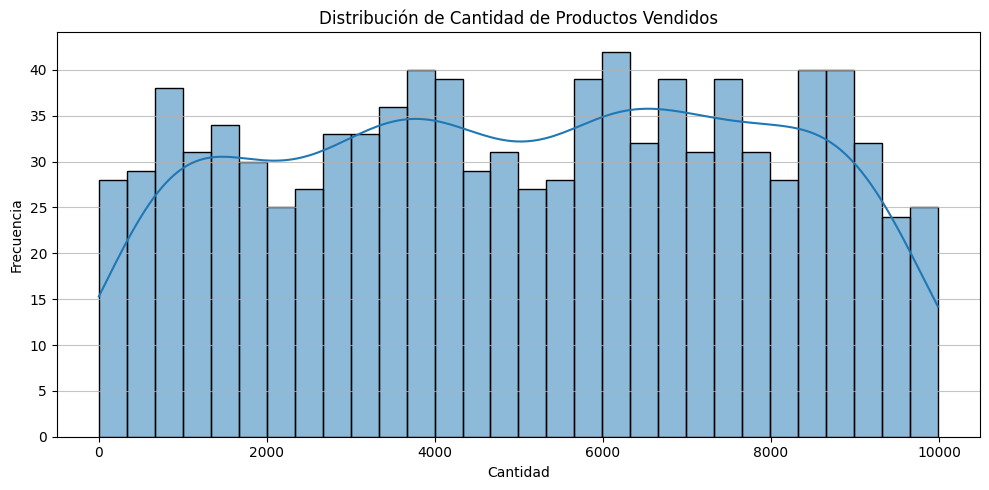

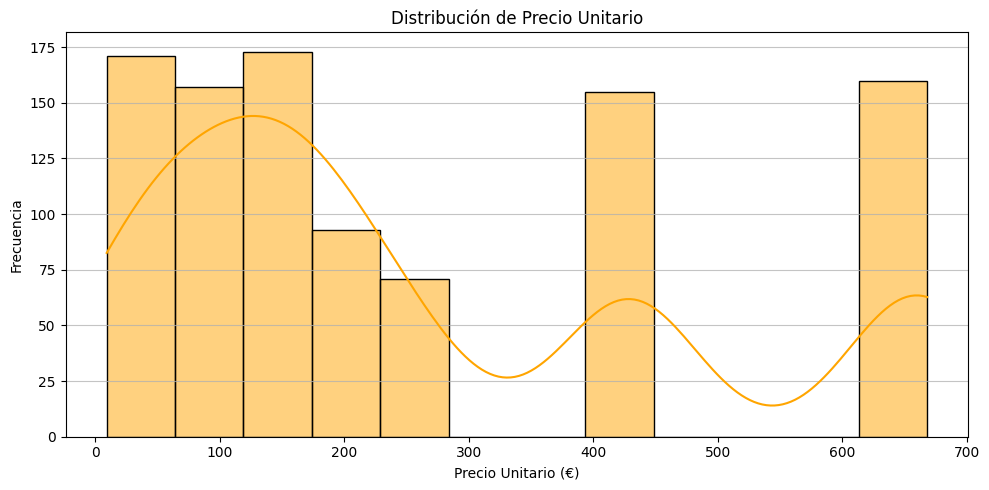

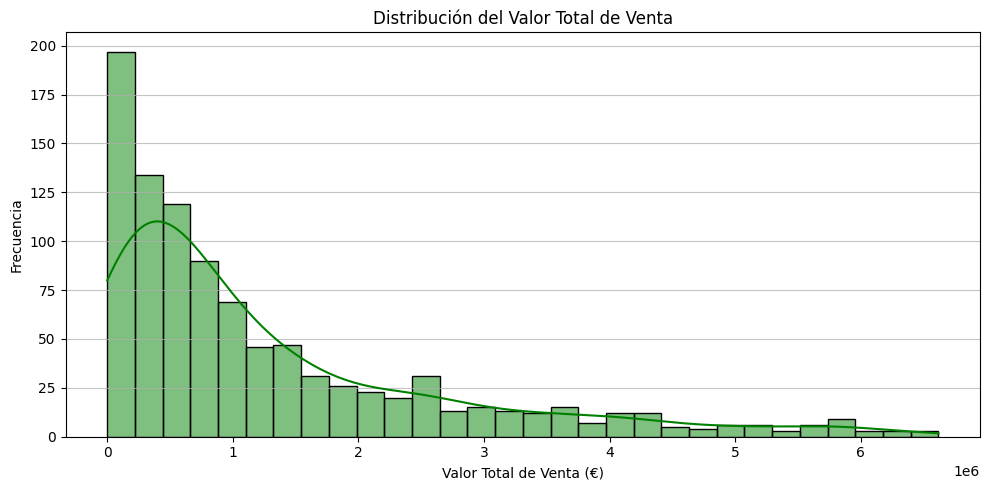

C:\Users\Diego\AppData\Local\Temp\ipykernel_10676\1064535862.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='producto', data=df_ventas_pd, order=df_ventas_pd['producto'].value_counts().index, palette='viridis')


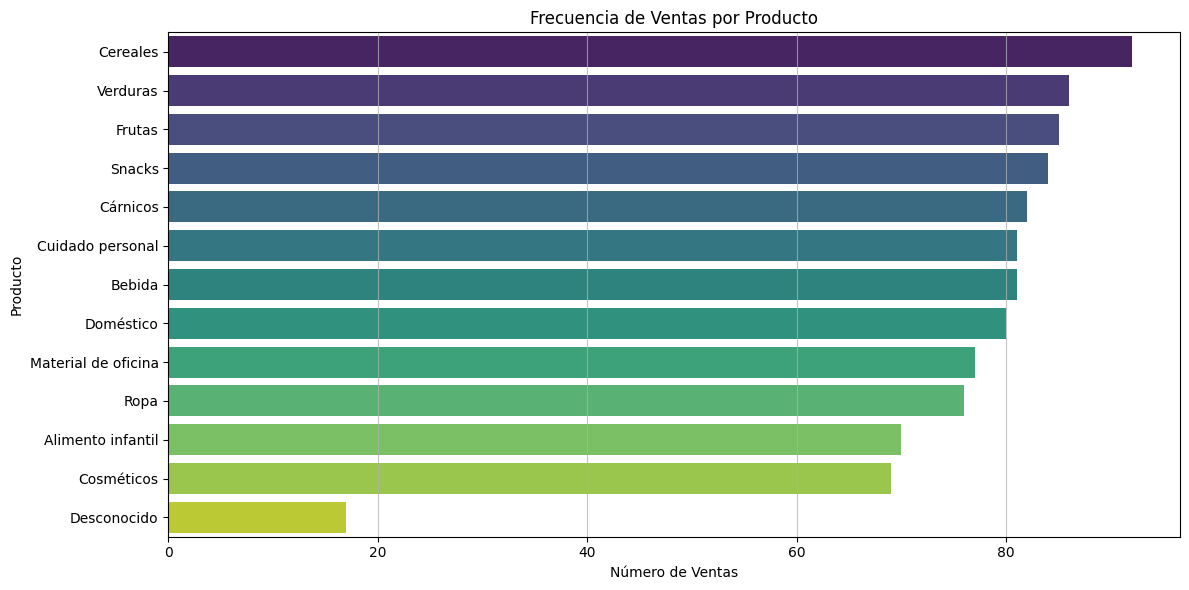

C:\Users\Diego\AppData\Local\Temp\ipykernel_10676\1064535862.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='region', data=df_ventas_pd, order=df_ventas_pd['region'].value_counts().index, palette='plasma')


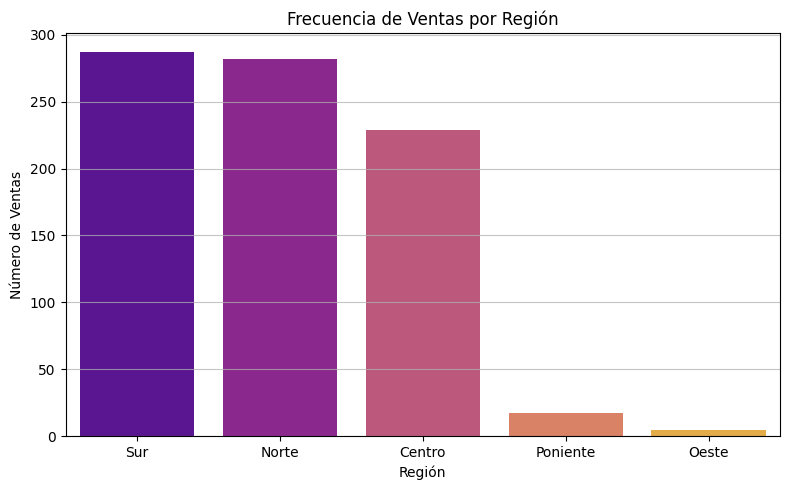

In [35]:

# 5.2. Distribuciones
print("\n--- Visualización de Distribuciones ---")

# Distribución de 'cantidad'
plt.figure(figsize=(10, 5))
sns.histplot(df_ventas_pd['cantidad'], bins=len(df_ventas_pd['cantidad'].unique()) if len(df_ventas_pd['cantidad'].unique()) < 50 else 30, kde=True)
plt.title('Distribución de Cantidad de Productos Vendidos')
plt.xlabel('Cantidad')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# Distribución de 'precio_unitario'
plt.figure(figsize=(10, 5))
sns.histplot(df_ventas_pd['precio_unitario'], bins=len(df_ventas_pd['precio_unitario'].unique()) if len(df_ventas_pd['precio_unitario'].unique()) < 50 else 30, kde=True, color='orange')
plt.title('Distribución de Precio Unitario')
plt.xlabel('Precio Unitario (€)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# Distribución de 'valor_total_venta'
plt.figure(figsize=(10, 5))
sns.histplot(df_ventas_pd['valor_total_venta'], bins=len(df_ventas_pd['valor_total_venta'].unique()) if len(df_ventas_pd['valor_total_venta'].unique()) < 50 else 30, kde=True, color='green')
plt.title('Distribución del Valor Total de Venta')
plt.xlabel('Valor Total de Venta (€)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


#df_ventas_pl_without_nan = df_ventas_pl.drop_nulls().filter(pl.col('cantidad') > 0 & pl.col('precio_unitario') > 0 & pl.col("producto") != "desconocido")
# Distribución de ventas por 'producto' (gráfico de barras)
plt.figure(figsize=(12, 6))
# Para el orden, Polars: df_ventas_pl.group_by('producto').agg(pl.count().alias('count')).sort('count', descending=True).select('producto').to_series().to_list()
sns.countplot(y='producto', data=df_ventas_pd, order=df_ventas_pd['producto'].value_counts().index, palette='viridis')
plt.title('Frecuencia de Ventas por Producto')
plt.xlabel('Número de Ventas')
plt.ylabel('Producto')
plt.grid(axis='x', alpha=0.75)
plt.tight_layout()
plt.show()

# Distribución de ventas por 'region' (gráfico de barras)
plt.figure(figsize=(8, 5))
sns.countplot(x='region', data=df_ventas_pd, order=df_ventas_pd['region'].value_counts().index, palette='plasma')
plt.title('Frecuencia de Ventas por Región')
plt.xlabel('Región')
plt.ylabel('Número de Ventas')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


--- Visualización de Relaciones entre Variables ---

Matriz de Correlación de Variables Numéricas:
                   cantidad  precio_unitario  valor_total_venta
cantidad           1.000000        -0.039989           0.504649
precio_unitario   -0.039989         1.000000           0.722235
valor_total_venta  0.504649         0.722235           1.000000


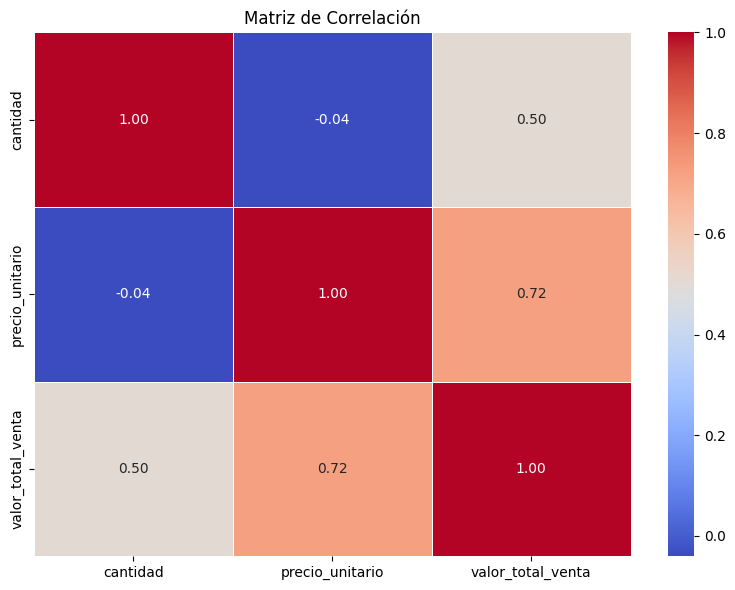

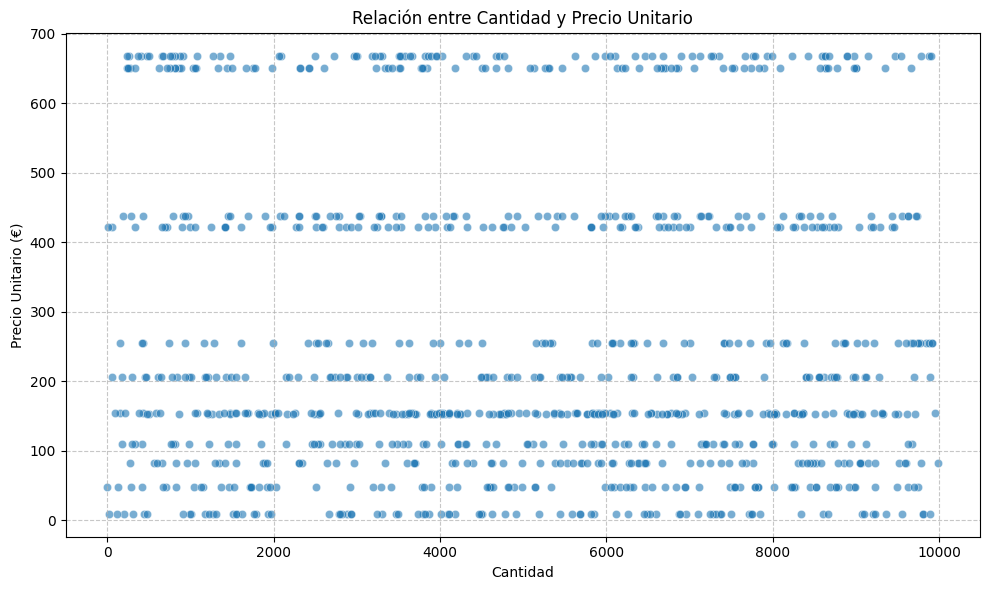

C:\Users\Diego\AppData\Local\Temp\ipykernel_10676\912221307.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='valor_total_venta', data=df_ventas_pd, palette='viridis')


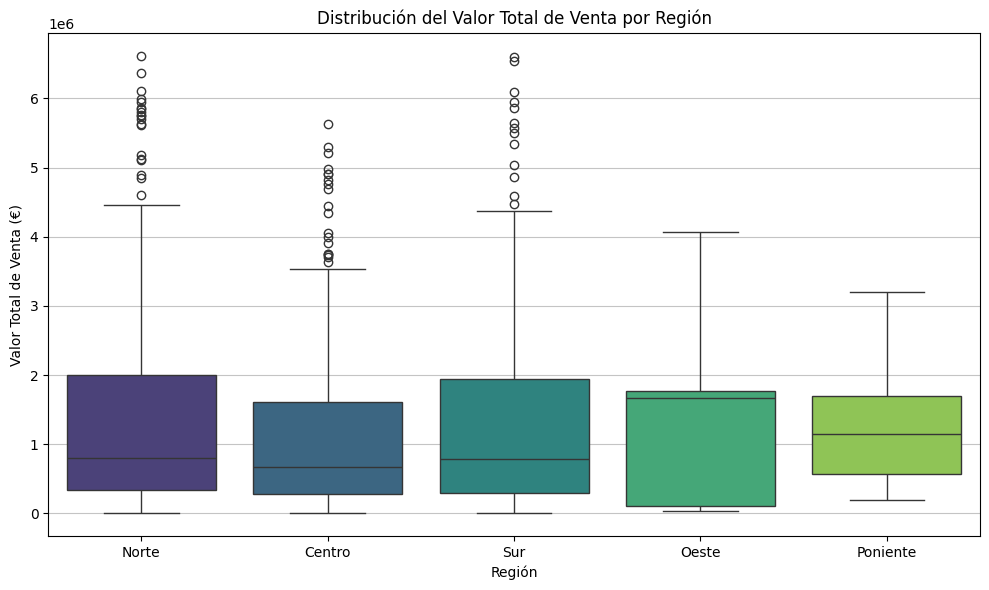

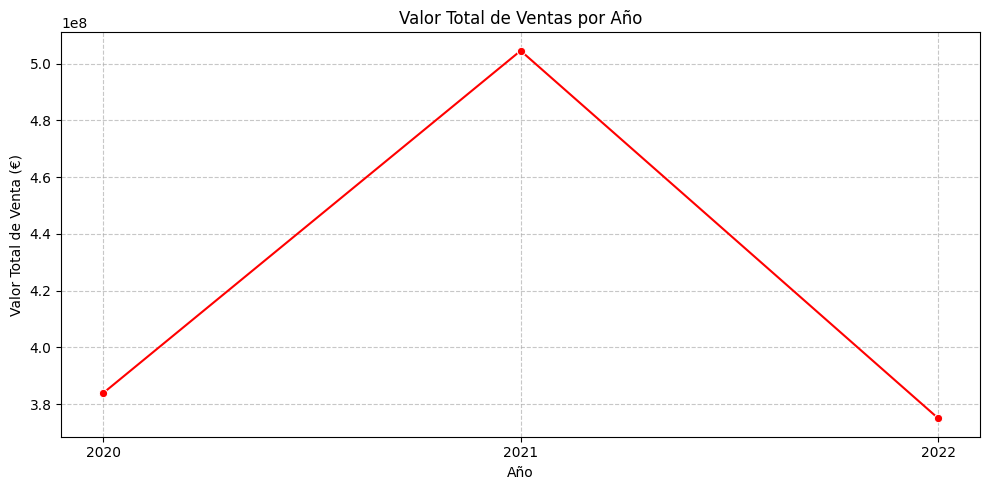

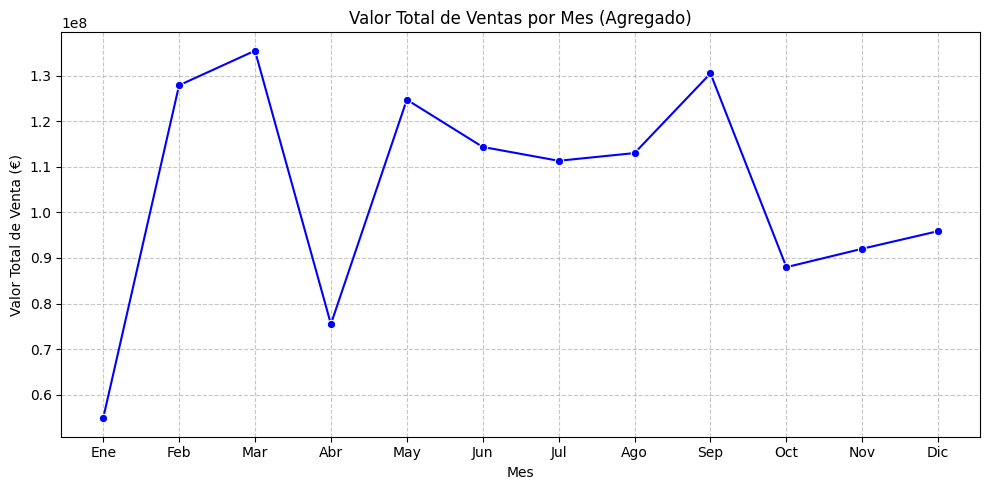

In [30]:
# 5.3. Relaciones entre Variables
print("\n--- Visualización de Relaciones entre Variables ---")

# Matriz de correlación para variables numéricas
numeric_cols = ['cantidad', 'precio_unitario', 'valor_total_venta']
# En Polars: correlation_matrix_pl = df_ventas_pl.select(numeric_cols).corr()
correlation_matrix = df_ventas_pd[numeric_cols].corr()
print("\nMatriz de Correlación de Variables Numéricas:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

# Gráficos de dispersión para identificar relaciones entre pares de variables
# Relación entre Cantidad y Precio Unitario
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cantidad', y='precio_unitario', data=df_ventas_pd, alpha=0.6)
plt.title('Relación entre Cantidad y Precio Unitario')
plt.xlabel('Cantidad')
plt.ylabel('Precio Unitario (€)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráficos de cajas (box plots) para comparar distribuciones entre categorías
# Distribución de Valor Total de Venta por Región
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='valor_total_venta', data=df_ventas_pd, palette='viridis')
plt.title('Distribución del Valor Total de Venta por Región')
plt.xlabel('Región')
plt.ylabel('Valor Total de Venta (€)')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# Análisis de Ventas a lo largo del tiempo (por año y mes)
# Ventas totales por año
# En Polars: ventas_por_año_pl = df_ventas_pl.group_by('año_venta').agg(pl.sum('valor_total_venta').alias('total_ventas')).sort('año_venta')
ventas_por_año = df_ventas_pd.groupby('año_venta')['valor_total_venta'].sum()
plt.figure(figsize=(10, 5))
sns.lineplot(x=ventas_por_año.index, y=ventas_por_año.values, marker='o', color='red')
plt.title('Valor Total de Ventas por Año')
plt.xlabel('Año')
plt.ylabel('Valor Total de Venta (€)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(ventas_por_año.index)
plt.tight_layout()
plt.show()

# Ventas totales por mes (agregando todos los años)
# En Polars: ventas_por_mes_pl = df_ventas_pl.group_by('mes_venta').agg(pl.sum('valor_total_venta').alias('total_ventas')).sort('mes_venta')
ventas_por_mes = df_ventas_pd.groupby('mes_venta')['valor_total_venta'].sum().sort_index()
plt.figure(figsize=(10, 5))
sns.lineplot(x=ventas_por_mes.index, y=ventas_por_mes.values, marker='o', color='blue')
plt.title('Valor Total de Ventas por Mes (Agregado)')
plt.xlabel('Mes')
plt.ylabel('Valor Total de Venta (€)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.tight_layout()
plt.show()

In [32]:
print("\n--- Análisis Exploratorio de Datos (EDA) con Polars Finalizado ---")

# --- Reporte para LLM ---
print("\n\n--- Generando Reporte Resumido para LLM ---")

report_lines = []
report_lines.append("## Reporte de Análisis de Datos de Ventas\n")
report_lines.append("Este reporte resume el Análisis Exploratorio de Datos (EDA) realizado sobre un dataset de ventas.\n")

report_lines.append("### 1. Resumen del Dataset y Preprocesamiento:\n")
report_lines.append(f"- El dataset inicial contenía {initial_rows} filas y {df_ventas_pl.shape[1]} columnas[cite: 11].")
report_lines.append(f"- Se realizó una limpieza de datos, incluyendo la conversión de 'fecha_venta' a formato de fecha, 'precio_unitario' y 'cantidad' a numérico[cite: 17].")
report_lines.append(f"- Se manejaron valores nulos, imputando 'Desconocido' para productos vacíos y eliminando filas con valores nulos críticos[cite: 17].")
report_lines.append(f"- Se eliminaron {rows_removed_zero_qty} registros donde la cantidad de productos vendidos era cero[cite: 17].")
report_lines.append("- Se crearon nuevas características como 'valor_total_venta' y 'año_venta', 'mes_venta' a partir de la fecha de venta[cite: 17].")
report_lines.append(f"- El dataset final para el análisis contiene {df_ventas_pl.shape[0]} filas.\n")


report_lines.append("### 2. Hallazgos Clave del Análisis Exploratorio de Datos (EDA):\n")

# Hallazgos de Estadísticas Descriptivas
mean_total_sale = df_ventas_pl['valor_total_venta'].mean()
median_total_sale = df_ventas_pl['valor_total_venta'].median()
report_lines.append(f"- El valor total de venta promedio es de aproximadamente {mean_total_sale:.2f} € y la mediana es {median_total_sale:.2f} €[cite: 20].")

# Hallazgos de Frecuencias Categóricas
top_product = df_ventas_pl.group_by('producto').agg(pl.sum('valor_total_venta').alias('total_sales')).sort('total_sales', descending=True).head(1)
if not top_product.is_empty():
    report_lines.append(f"- El producto que genera el mayor valor total de ventas es '{top_product['producto'][0]}'[cite: 20, 26].")

top_region = df_ventas_pl.group_by('region').agg(pl.sum('valor_total_venta').alias('total_sales')).sort('total_sales', descending=True).head(1)
if not top_region.is_empty():
    report_lines.append(f"- La región con el mayor valor total de ventas es '{top_region['region'][0]}'[cite: 20, 26].")

# Hallazgos de Correlación
if not correlation_matrix.empty:
    corr_qty_price = correlation_matrix.loc['cantidad', 'precio_unitario']
    corr_qty_total_sale = correlation_matrix.loc['cantidad', 'valor_total_venta']
    report_lines.append(f"- Se observó una correlación de {corr_qty_price:.2f} entre la cantidad y el precio unitario[cite: 22].")
    report_lines.append(f"- Existe una fuerte correlación positiva ({corr_qty_total_sale:.2f}) entre la cantidad de productos vendidos y el valor total de la venta, lo cual es esperado[cite: 22].")

# Hallazgos de Tendencias Temporales
if not ventas_por_año.empty:
    min_year = ventas_por_año.index.min()
    max_year = ventas_por_año.index.max()
    report_lines.append(f"- El análisis de ventas abarca desde el año {min_year} hasta el {max_year}[cite: 20].")
    if ventas_por_año.shape[0] > 1 and ventas_por_año.iloc[-1] > ventas_por_año.iloc[0]:
        report_lines.append(f"- Se observa una tendencia general de crecimiento en el valor total de ventas a lo largo de los años[cite: 26].")

print("".join(report_lines))

print("\n--- Reporte para LLM Generado ---")


--- Análisis Exploratorio de Datos (EDA) con Polars Finalizado ---


--- Generando Reporte Resumido para LLM ---
## Reporte de Análisis de Datos de Ventas
Este reporte resume el Análisis Exploratorio de Datos (EDA) realizado sobre un dataset de ventas.
### 1. Resumen del Dataset y Preprocesamiento:
- El dataset inicial contenía 1000 filas y 10 columnas[cite: 11].- Se realizó una limpieza de datos, incluyendo la conversión de 'fecha_venta' a formato de fecha, 'precio_unitario' y 'cantidad' a numérico[cite: 17].- Se manejaron valores nulos, imputando 'Desconocido' para productos vacíos y eliminando filas con valores nulos críticos[cite: 17].- Se eliminaron 9 registros donde la cantidad de productos vendidos era cero[cite: 17].- Se crearon nuevas características como 'valor_total_venta' y 'año_venta', 'mes_venta' a partir de la fecha de venta[cite: 17].- El dataset final para el análisis contiene 980 filas.
### 2. Hallazgos Clave del Análisis Exploratorio de Datos (EDA):
- El valor total


--- Analizando Productos Estratégicos ---


C:\Users\Diego\AppData\Local\Temp\ipykernel_10676\585169491.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_by_region = top_products_by_region.groupby('region').apply(lambda x: x.nlargest(5, 'valor_total_venta')).reset_index(drop=True)


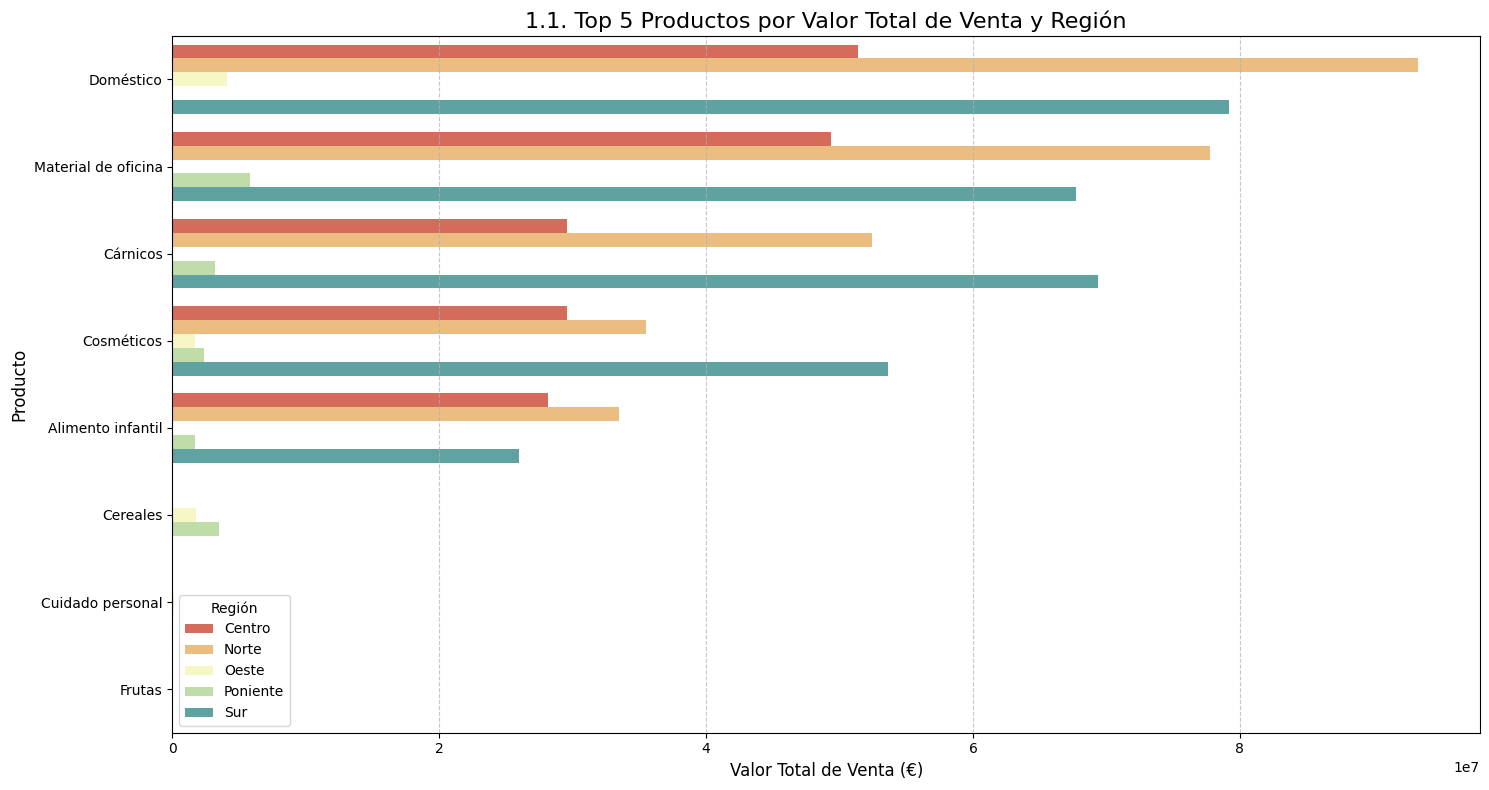

In [36]:
#### **Objetivos del Análisis**

# 1. **Productos estratégicos**:
#    - ¿Cuáles son los 5 productos con mayor rentabilidad por región?
#    - ¿Existen productos infravalorados con potencial de crecimiento?

print("\n--- Analizando Productos Estratégicos ---")

# Calcular rentabilidad como valor_total_venta
# Asumiremos que "mayor rentabilidad" se refiere a "mayor valor total de venta".
# Si tuviéramos margen de beneficio, usaríamos esa métrica.

# Agrupar por región y producto, sumar valor_total_venta y obtener los top 5 por región
top_products_by_region = df_ventas_pd.groupby(['region', 'producto'])['valor_total_venta'].sum().reset_index()
top_5_by_region = top_products_by_region.groupby('region').apply(lambda x: x.nlargest(5, 'valor_total_venta')).reset_index(drop=True)

plt.figure(figsize=(15, 8))
sns.barplot(
    x='valor_total_venta',
    y='producto',
    hue='region',
    data=top_5_by_region.sort_values(by=['region', 'valor_total_venta'], ascending=[True, False]),
    palette='Spectral'
)
plt.title('1.1. Top 5 Productos por Valor Total de Venta y Región', fontsize=16)
plt.xlabel('Valor Total de Venta (€)', fontsize=12)
plt.ylabel('Producto', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title='Región')
plt.tight_layout()
plt.show()

# Interpretación: Este gráfico permite comparar visualmente la contribución de los productos
# más vendidos en términos de ingresos dentro de cada región. Se pueden identificar productos
# que son fuertes en todas las regiones versus aquellos que tienen un desempeño destacado
# solo en una específica.

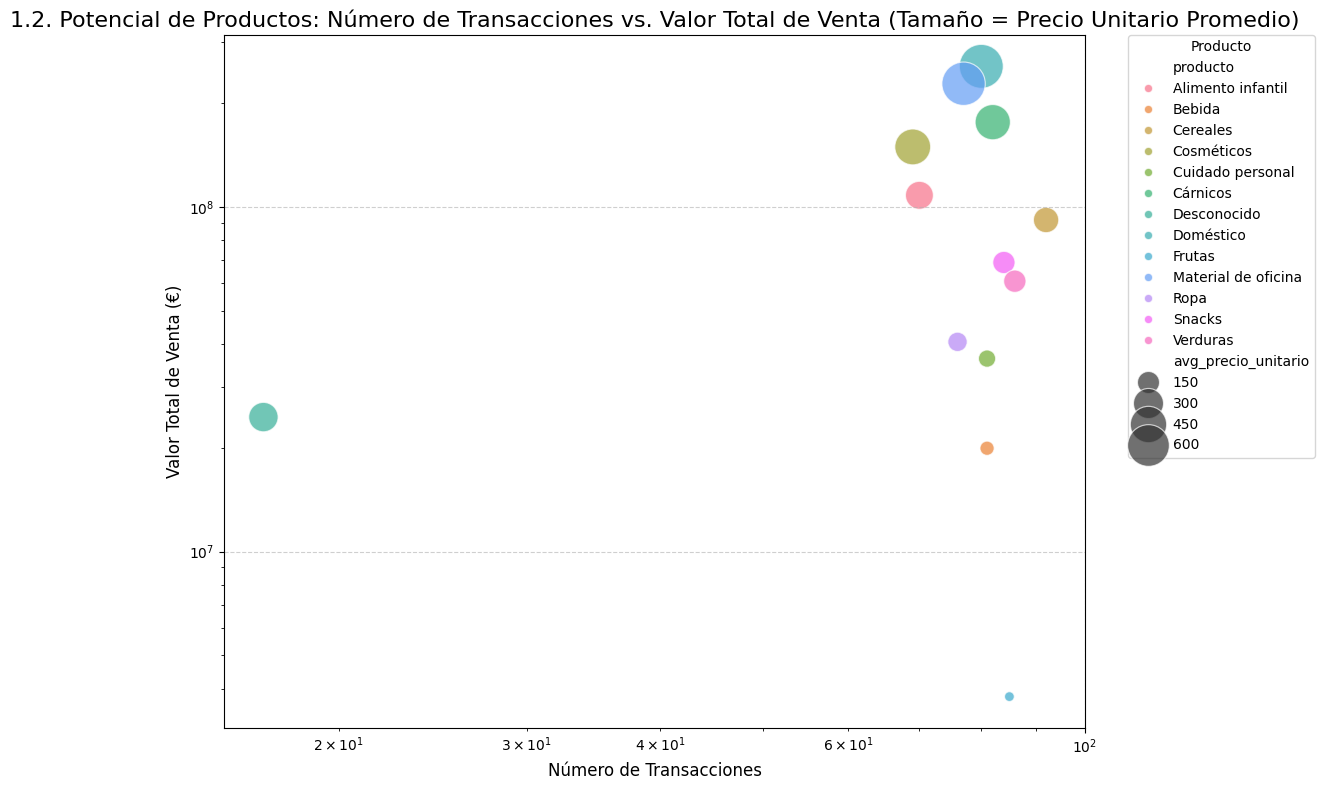

In [37]:
# Productos infravalorados con potencial de crecimiento:
# Esto es más complejo y requiere un análisis heurístico o modelos predictivos.
# Una aproximación inicial podría ser buscar productos con alta 'cantidad' pero bajo 'precio_unitario'
# o productos con un crecimiento reciente significativo en ventas donde antes eran bajos.
# Para este EDA, podríamos visualizar productos con baja venta total pero con un volumen de transacciones decente.

# Calcular el número de transacciones por producto
transactions_per_product = df_ventas_pd['producto'].value_counts().reset_index()
transactions_per_product.columns = ['producto', 'num_transactions']

# Unir con el valor total de ventas por producto
product_performance = df_ventas_pd.groupby('producto')['valor_total_venta'].sum().reset_index()
product_performance = product_performance.merge(transactions_per_product, on='producto')

# Crear un 'bubble chart' o 'scatter plot' para visualizar relación entre valor total, número de transacciones y, si es posible, precio unitario promedio
# Precio unitario promedio por producto
avg_price_per_product = df_ventas_pd.groupby('producto')['precio_unitario'].mean().reset_index()
avg_price_per_product.rename(columns={'precio_unitario': 'avg_precio_unitario'}, inplace=True)
product_performance = product_performance.merge(avg_price_per_product, on='producto')

plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='num_transactions',
    y='valor_total_venta',
    size='avg_precio_unitario', # El tamaño de la burbuja representa el precio unitario promedio
    hue='producto',
    data=product_performance,
    sizes=(50, 1000), # Rango de tamaños para las burbujas
    alpha=0.7
)
plt.title('1.2. Potencial de Productos: Número de Transacciones vs. Valor Total de Venta (Tamaño = Precio Unitario Promedio)', fontsize=16)
plt.xlabel('Número de Transacciones', fontsize=12)
plt.ylabel('Valor Total de Venta (€)', fontsize=12)
plt.xscale('log') # Escala logarítmica para num_transactions si hay mucha variación
plt.yscale('log') # Escala logarítmica para valor_total_venta si hay mucha variación
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Producto', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar layout para la leyenda
plt.show()

# Interpretación: Los productos "infravalorados" podrían ser aquellos con un número decente de transacciones
# pero un valor total de venta relativamente bajo (burbujas en la parte inferior-derecha)
# y/o un precio unitario promedio bajo (burbujas pequeñas). Esto podría indicar oportunidad
# para ajustar precios o promocionar ventas cruzadas.
# Ej: si 'Cuidado personal' tiene muchas transacciones pero bajo valor total, podría ser infravalorado.

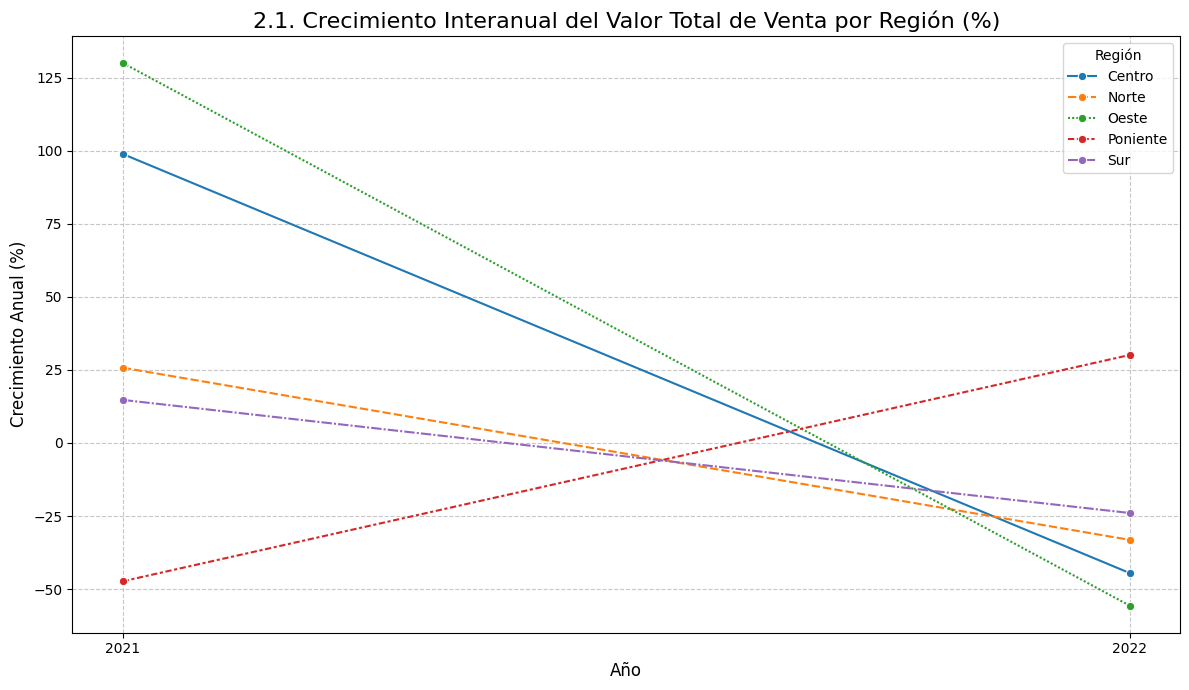

In [38]:
# Crecimiento interanual por región
# Requiere al menos dos años de datos.
# Agrupar por año y región, y calcular el valor total de ventas
sales_by_year_region = df_ventas_pd.groupby(['año_venta', 'region'])['valor_total_venta'].sum().reset_index()

# Pivotar para calcular el crecimiento interanual
sales_pivot = sales_by_year_region.pivot(index='año_venta', columns='region', values='valor_total_venta')
growth_rates = sales_pivot.pct_change() * 100 # Porcentaje de cambio
growth_rates.dropna(inplace=True) # Eliminar el primer año (no hay crecimiento previo)

if not growth_rates.empty:
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=growth_rates, marker='o')
    plt.title('2.1. Crecimiento Interanual del Valor Total de Venta por Región (%)', fontsize=16)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('Crecimiento Anual (%)', fontsize=12)
    plt.xticks(growth_rates.index)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Región')
    plt.tight_layout()
    plt.show()


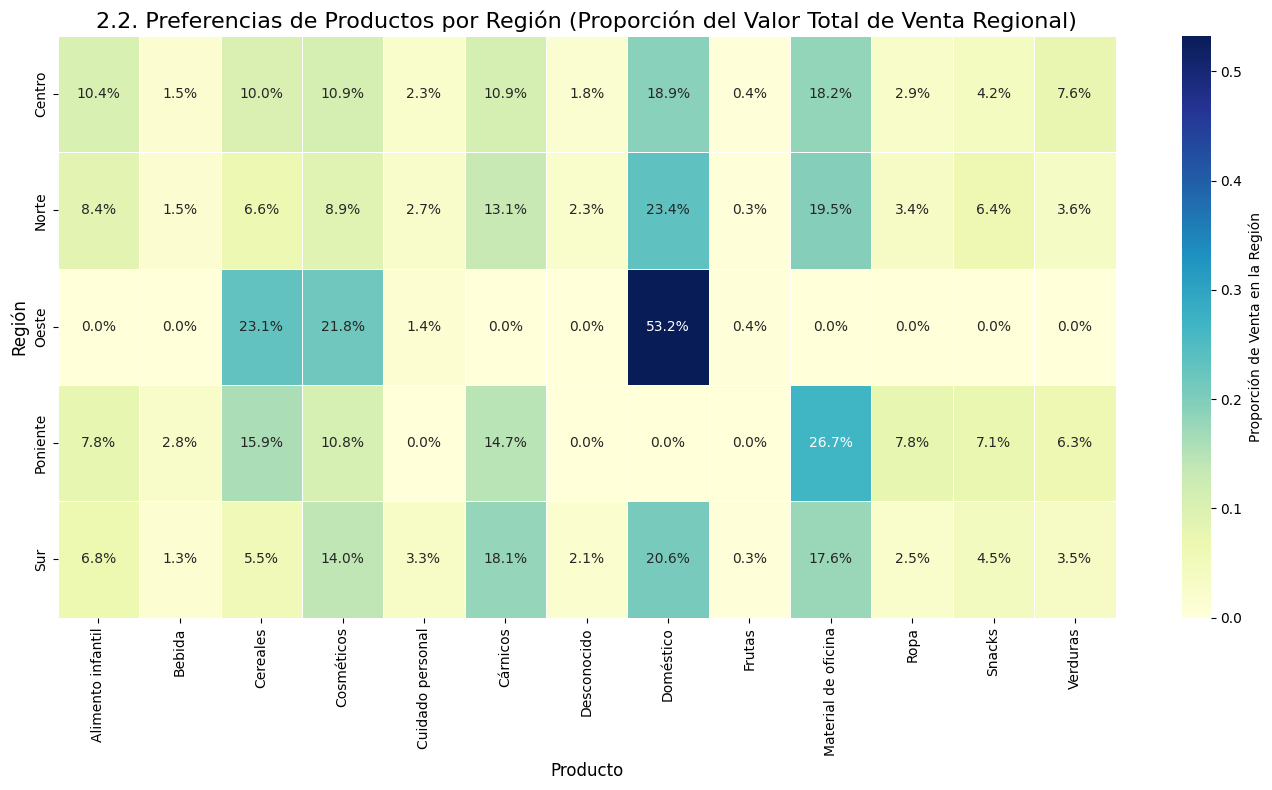

In [39]:
# Variación de preferencias de productos entre Norte/Centro/Sur
# Utilizaremos un heatmap de la proporción de ventas por producto y región.

# Calcular el valor total de ventas por producto y región
product_region_sales = df_ventas_pd.groupby(['region', 'producto'])['valor_total_venta'].sum().unstack(fill_value=0)

# Calcular la proporción de cada producto dentro de su región
# Dividir cada valor por la suma total de ventas de esa región
product_region_proportion = product_region_sales.apply(lambda x: x / x.sum(), axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(
    product_region_proportion,
    annot=True,
    fmt=".1%", # Formato en porcentaje
    cmap="YlGnBu",
    linewidths=.5,
    cbar_kws={'label': 'Proporción de Venta en la Región'}
)
plt.title('2.2. Preferencias de Productos por Región (Proporción del Valor Total de Venta Regional)', fontsize=16)
plt.xlabel('Producto', fontsize=12)
plt.ylabel('Región', fontsize=12)
plt.tight_layout()
plt.show()

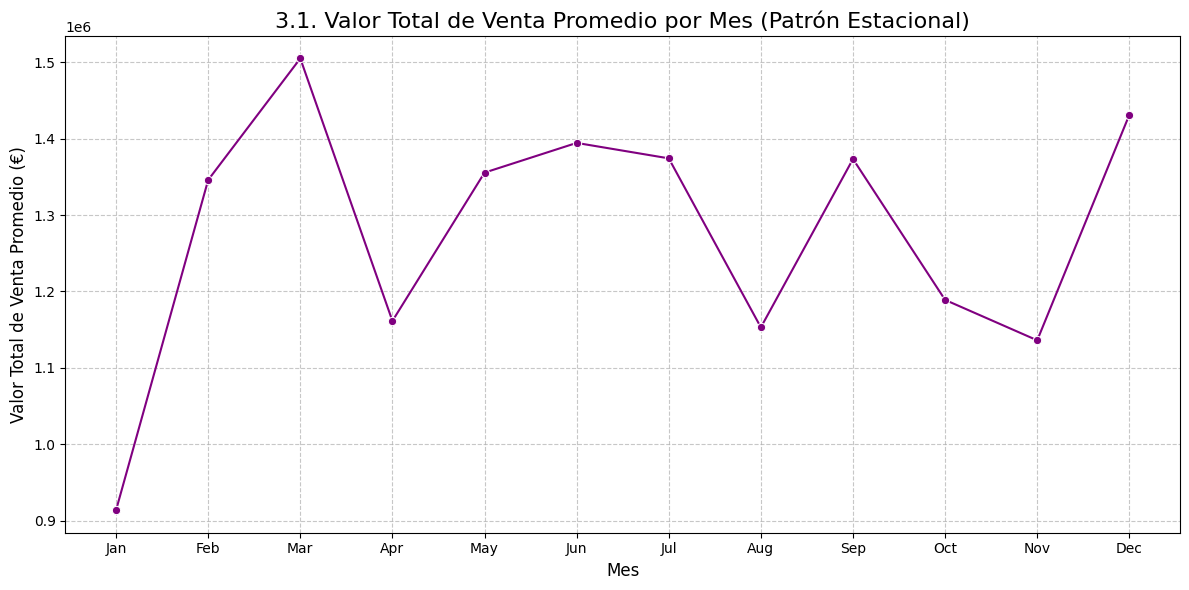

In [42]:
# Picos estacionales predecibles (valor total de venta por mes)
# Agrupar por mes (promedio de todos los años para ver el patrón estacional general)
monthly_avg_sales = df_ventas_pd.groupby('mes_venta')['valor_total_venta'].mean().reset_index()
monthly_avg_sales['mes_nombre'] = monthly_avg_sales['mes_venta'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))

# Ordenar los meses correctamente
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg_sales['mes_nombre'] = pd.Categorical(monthly_avg_sales['mes_nombre'], categories=[pd.to_datetime(str(i), format='%m').strftime('%b') for i in range(1,13)], ordered=True)
monthly_avg_sales = monthly_avg_sales.sort_values('mes_nombre')

plt.figure(figsize=(12, 6))
sns.lineplot(x='mes_nombre', y='valor_total_venta', data=monthly_avg_sales, marker='o', color='purple')
plt.title('3.1. Valor Total de Venta Promedio por Mes (Patrón Estacional)', fontsize=16)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Valor Total de Venta Promedio (€)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

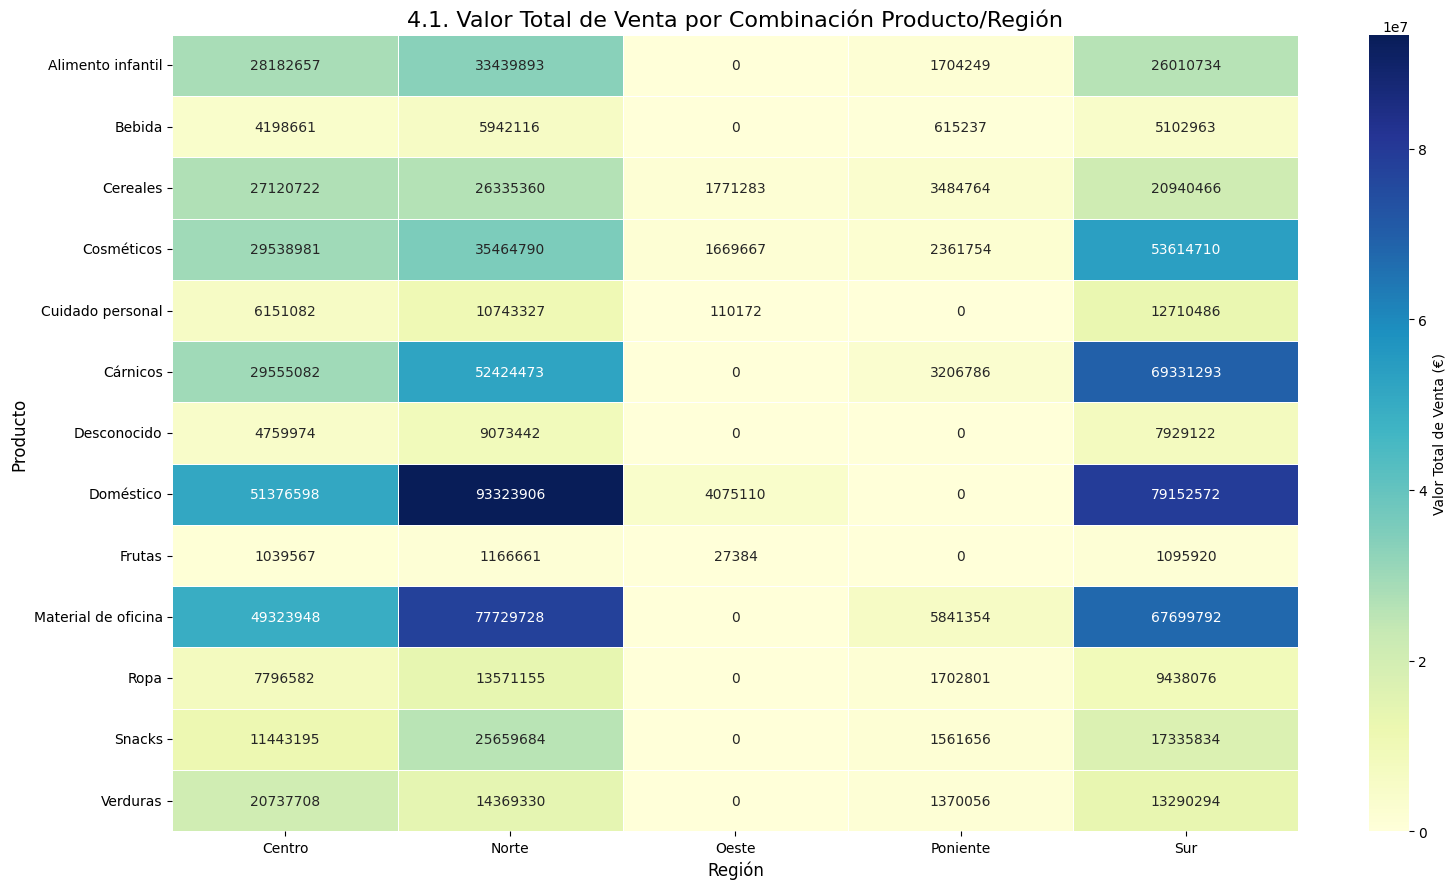

In [43]:
# Agrupar por producto y región, sumar valor_total_venta
product_region_value = df_ventas_pd.groupby(['producto', 'region'])['valor_total_venta'].sum().unstack(fill_value=0)

plt.figure(figsize=(16, 9))
sns.heatmap(
    product_region_value,
    annot=True,
    fmt=".0f", # Sin decimales
    cmap="YlGnBu",
    linewidths=.5,
    cbar_kws={'label': 'Valor Total de Venta (€)'}
)
plt.title('4.1. Valor Total de Venta por Combinación Producto/Región', fontsize=16)
plt.xlabel('Región', fontsize=12)
plt.ylabel('Producto', fontsize=12)
plt.tight_layout()
plt.show()

<Axes: xlabel='fecha_orden', ylabel='valor_total_venta'>

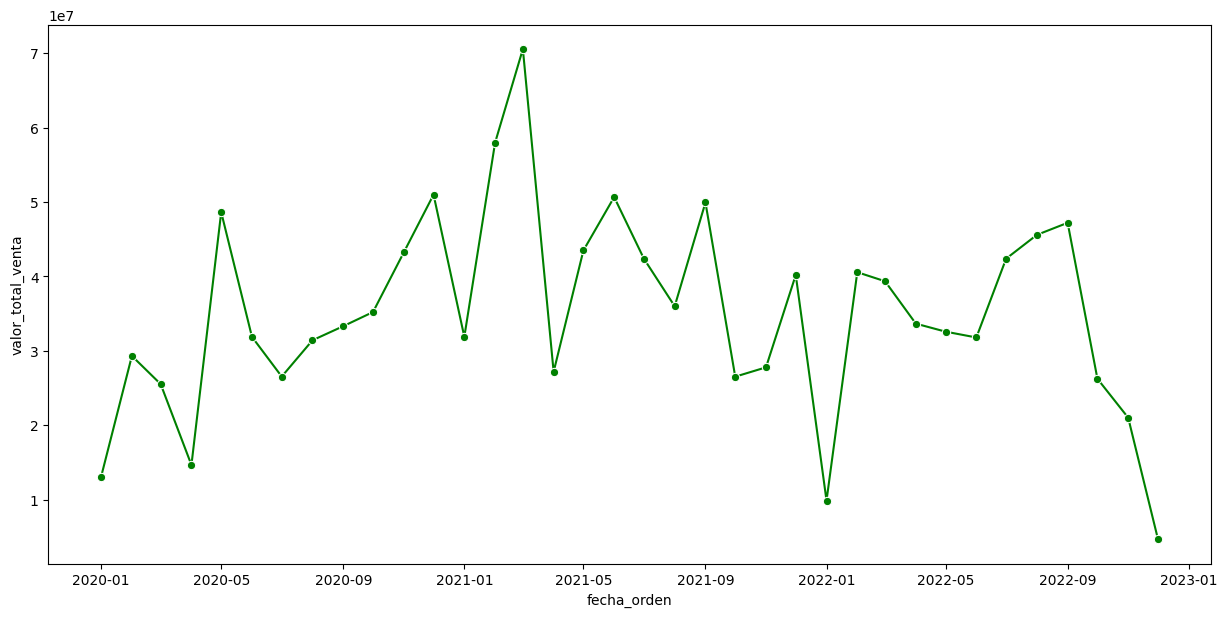

In [44]:
# Ventas por mes (incluyendo el año para ver la tendencia a lo largo del tiempo)
df_ventas_pd['año_mes'] = df_ventas_pd['fecha_venta'].dt.to_period('M').astype(str)
sales_over_time = df_ventas_pd.groupby('año_mes')['valor_total_venta'].sum().reset_index()
sales_over_time['fecha_orden'] = pd.to_datetime(sales_over_time['año_mes']) # Para ordenar correctamente en el plot
sales_over_time = sales_over_time.sort_values('fecha_orden')

plt.figure(figsize=(15, 7))
sns.lineplot(x='fecha_orden', y='valor_total_venta', data=sales_over_time, marker='o', color='green')
